In [1]:
# Mathieu Blondel, September 2010
# License: BSD 3 clause
# http://www.mblondel.org/journal/2010/09/19/support-vector-machines-in-python/

import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
             
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x - y) ** 2 / (sigma ** 2))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # Solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non-zero Lagrange multipliers.
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv_X = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points." % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv_X[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv_X in zip(self.a, self.sv_y, self.sv_X):
                    s += a * sv_y * self.kernel(X[i], sv_X)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

In [2]:
from matplotlib import pyplot as plt

def gen_lin_separable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    np.random.seed(1)
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def gen_non_lin_separable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    np.random.seed(1)
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def gen_lin_separable_overlap_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    np.random.seed(1)
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

def plot_margin(X1_train, X2_train, clf):
    def f(x, w, b, c=0):
        # given x, return y such that [x,y] in on the line
        # w.x + b = c
        return (-w[0] * x - b + c) / w[1]

    plt.plot(X1_train[:,0], X1_train[:,1], "ro")
    plt.plot(X2_train[:,0], X2_train[:,1], "bo")
    plt.scatter(clf.sv_X[:,0], clf.sv_X[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -4; a1 = f(a0, clf.w, clf.b)
    b0 = 4; b1 = f(b0, clf.w, clf.b)
    plt.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
    plt.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
    plt.plot([a0,b0], [a1,b1], "k--")

    plt.axis("tight")
    plt.show()

def plot_contour(X1_train, X2_train, clf):
    plt.plot(X1_train[:,0], X1_train[:,1], "ro")
    plt.plot(X2_train[:,0], X2_train[:,1], "bo")
    plt.scatter(clf.sv_X[:,0], clf.sv_X[:,1], s=100, c="g")

    X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.project(X).reshape(X1.shape)
    plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    plt.axis("tight")
    plt.show()

def test_linear():
    X1, y1, X2, y2 = gen_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM()
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    # correct = np.sum(y_predict == y_test)
    # print("%d out of %d predictions correct" % (correct, len(y_predict)))
    
    plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

def test_non_linear(kernel=gaussian_kernel):
    X1, y1, X2, y2 = gen_non_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(kernel)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    # correct = np.sum(y_predict == y_test)
    # print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

def test_soft(kernel=linear_kernel):
    X1, y1, X2, y2 = gen_lin_separable_overlap_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)
    
    if kernel is not linear_kernel:
        C = 99999999999
    else:
        C = 1000.1
    clf = SVM(kernel=kernel, C=C)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    # correct = np.sum(y_predict == y_test)
    # print("%d out of %d predictions correct" % (correct, len(y_predict)))
    
    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

     pcost       dcost       gap    pres   dres
 0: -1.5948e+01 -2.9371e+01  5e+02  2e+01  2e+00
 1: -1.7098e+01 -1.1483e+01  2e+02  7e+00  5e-01
 2: -2.3508e+01 -1.0900e+01  1e+02  4e+00  3e-01
 3: -7.6021e+00 -4.1259e+00  1e+01  4e-01  3e-02
 4: -2.8959e+00 -3.4259e+00  7e-01  4e-03  3e-04
 5: -3.2437e+00 -3.2972e+00  6e-02  1e-04  8e-06
 6: -3.2908e+00 -3.2914e+00  6e-04  1e-06  8e-08
 7: -3.2913e+00 -3.2913e+00  6e-06  1e-08  8e-10
 8: -3.2913e+00 -3.2913e+00  6e-08  1e-10  8e-12
Optimal solution found.
3 support vectors out of 180 points.


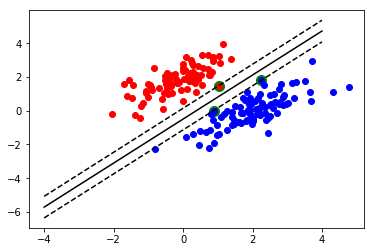

In [3]:
test_linear()

     pcost       dcost       gap    pres   dres
 0: -1.5201e+02 -3.5613e+02  2e+02  0e+00  2e+00
 1: -3.2809e+02 -3.3316e+02  5e+00  3e-14  1e+00
 2: -2.1685e+04 -2.1689e+04  4e+00  9e-12  1e+00
 3: -1.3101e+08 -1.3101e+08  2e+02  3e-08  1e+00
 4: -2.1328e+09 -2.1328e+09  3e+03  6e-07  1e+00
Terminated (singular KKT matrix).
180 support vectors out of 180 points.


/home/murali/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


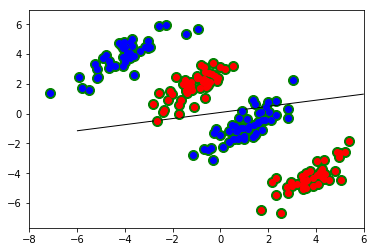

In [4]:
test_non_linear(linear_kernel)

     pcost       dcost       gap    pres   dres
 0: -3.9533e+01 -9.6030e+01  1e+03  4e+01  2e+00
 1: -8.6437e+01 -1.2168e+02  8e+02  2e+01  1e+00
 2: -7.7171e+01 -5.0216e+01  4e+02  1e+01  6e-01
 3: -4.1348e+00 -9.2785e-01  4e+01  8e-01  5e-02
 4: -3.9764e-01 -6.5101e-01  6e+00  1e-01  7e-03
 5: -1.7950e-01 -6.6203e-01  3e+00  4e-02  2e-03
 6: -6.9696e-02 -4.0301e-01  8e-01  8e-03  5e-04
 7: -1.2167e-01 -2.6693e-01  3e-01  2e-03  2e-04
 8: -1.5497e-01 -2.5358e-01  2e-01  1e-03  8e-05
 9: -1.8903e-01 -2.2100e-01  5e-02  3e-04  2e-05
10: -1.8814e-01 -2.1796e-01  4e-02  1e-04  6e-06
11: -2.0793e-01 -2.1182e-01  4e-03  6e-17  3e-14
12: -2.1064e-01 -2.1145e-01  8e-04  1e-16  3e-14
13: -2.1083e-01 -2.1143e-01  6e-04  2e-17  2e-14
14: -2.1137e-01 -2.1138e-01  1e-05  6e-17  3e-14
15: -2.1138e-01 -2.1138e-01  1e-07  6e-17  3e-14
Optimal solution found.
10 support vectors out of 180 points.


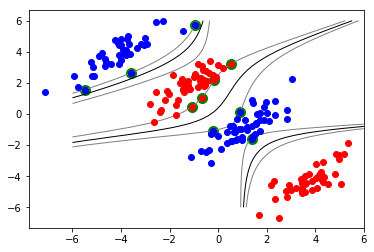

In [5]:
test_non_linear(polynomial_kernel)

     pcost       dcost       gap    pres   dres
 0: -2.2454e+01 -7.2640e+01  5e+02  2e+01  2e+00
 1: -2.2569e+01 -8.9434e+01  2e+02  7e+00  7e-01
 2: -2.1488e+01 -6.7080e+01  5e+01  4e-01  5e-02
 3: -3.2733e+01 -5.5001e+01  2e+01  1e-01  1e-02
 4: -3.9080e+01 -5.7223e+01  2e+01  7e-02  7e-03
 5: -5.1268e+01 -5.2330e+01  1e+00  1e-03  1e-04
 6: -5.2145e+01 -5.2164e+01  2e-02  2e-05  2e-06
 7: -5.2160e+01 -5.2160e+01  3e-04  2e-07  2e-08
 8: -5.2160e+01 -5.2160e+01  3e-06  2e-09  2e-10
Optimal solution found.
10 support vectors out of 180 points.


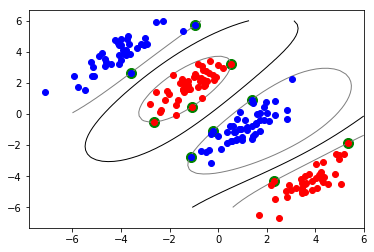

In [6]:
test_non_linear()

     pcost       dcost       gap    pres   dres
 0:  1.4647e+05 -9.8763e+07  3e+08  6e-01  6e-12
 1:  4.3556e+05 -2.1167e+07  3e+07  6e-02  2e-11
 2:  3.9832e+05 -3.5741e+06  5e+06  8e-03  3e-12
 3:  1.1532e+05 -6.2618e+05  8e+05  7e-04  2e-12
 4:  5.6879e+03 -8.7198e+04  9e+04  2e-05  2e-12
 5: -2.6912e+03 -3.3887e+04  3e+04  7e-06  2e-12
 6: -2.2980e+03 -3.1075e+04  3e+04  6e-06  2e-12
 7: -3.9037e+03 -2.9448e+04  3e+04  3e-06  2e-12
 8: -4.9598e+03 -1.9341e+04  1e+04  1e-06  2e-12
 9: -4.1920e+03 -1.6480e+04  1e+04  5e-07  2e-12
10: -5.3175e+03 -1.6918e+04  1e+04  3e-07  2e-12
11: -6.0520e+03 -1.3289e+04  7e+03  1e-07  2e-12
12: -5.3065e+03 -1.2434e+04  7e+03  1e-07  2e-12
13: -5.4123e+03 -1.0821e+04  5e+03  6e-08  2e-12
14: -6.1565e+03 -9.1095e+03  3e+03  9e-09  2e-12
15: -6.2949e+03 -9.2255e+03  3e+03  9e-09  2e-12
16: -6.4977e+03 -8.8783e+03  2e+03  6e-09  2e-12
17: -6.5542e+03 -8.8337e+03  2e+03  6e-09  2e-12
18: -6.4929e+03 -8.7506e+03  2e+03  5e-09  2e-12
19: -7.0445e+03 -7.66

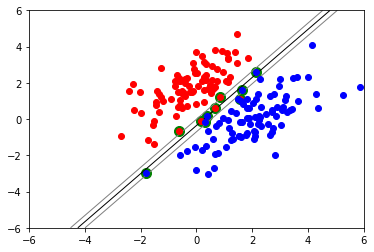

In [7]:
test_soft()

     pcost       dcost       gap    pres   dres
 0:  1.3028e+21 -3.8788e+23  8e+23  2e-01  8e-02
 1:  2.2255e+21 -9.1848e+22  2e+23  4e-02  8e+04
 2:  1.8321e+21 -3.0945e+22  5e+22  1e-02  2e+04
 3:  1.0568e+21 -1.6624e+22  2e+22  4e-03  8e+03
 4:  3.9868e+20 -5.4894e+21  8e+21  9e-04  2e+03
 5:  2.4936e+20 -1.5432e+21  2e+21  1e-04  3e+02
 6:  1.3763e+20 -6.4158e+20  8e+20  2e-05  4e+01
 7:  3.6217e+19 -1.0672e+20  1e+20  9e-05  2e+00
 8:  8.7135e+18 -2.2593e+19  3e+19  3e-05  2e-01
 9:  1.7139e+18 -4.2217e+18  6e+18  1e-04  7e-03
10:  3.0119e+17 -5.9262e+17  9e+17  2e-05  2e-03
11:  4.7574e+16 -6.4034e+16  1e+17  1e-05  2e-03
12:  6.8748e+15 -7.8445e+15  1e+16  7e-06  4e-04
13:  9.8818e+14 -1.1016e+15  2e+15  3e-06  3e-04
14:  1.4176e+14 -1.5657e+14  3e+14  2e-06  1e-04
15:  2.0321e+13 -2.2376e+13  4e+13  1e-07  4e-05
16:  2.9123e+12 -3.2032e+12  6e+12  1e-07  1e-05
17:  4.1732e+11 -4.5887e+11  9e+11  2e-08  6e-06
18:  5.9788e+10 -6.5759e+10  1e+11  1e-08  3e-06
19:  8.5624e+09 -9.42

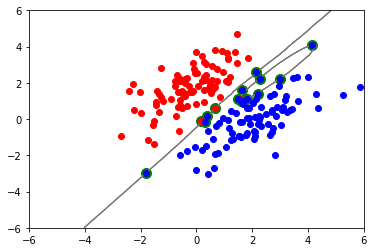

In [8]:
test_soft(polynomial_kernel)

     pcost       dcost       gap    pres   dres
 0:  3.0402e+22 -5.6985e+23  1e+24  3e-01  2e-04
 1:  2.8993e+22 -6.4768e+22  1e+23  1e-02  3e+04
 2:  6.6555e+21 -1.1998e+22  2e+22  1e-03  2e+03
 3:  9.4359e+20 -1.7076e+21  3e+21  2e-04  7e-05
 4:  1.6605e+20 -3.5941e+20  5e+20  2e-16  5e-05
 5:  2.4113e+19 -1.5485e+20  2e+20  6e-05  4e-05
 6:  5.4682e+18 -5.0590e+19  6e+19  1e-04  4e-05
 7:  1.3814e+18 -1.3363e+19  1e+19  2e-16  4e-05
 8:  4.7716e+17 -3.0100e+18  3e+18  2e-04  5e-05
 9:  2.7535e+17 -1.4181e+18  2e+18  3e-05  4e-05
10:  1.9228e+17 -1.2803e+18  1e+18  6e-05  3e-05
11:  7.2984e+16 -2.4751e+17  3e+17  5e-05  4e-05
12:  1.4223e+16 -3.0667e+16  4e+16  3e-05  3e-05
13:  5.1894e+15 -1.6989e+16  2e+16  2e-05  3e-05
14:  1.2308e+15 -2.8859e+15  4e+15  3e-05  2e-05
15:  2.3933e+14 -5.8717e+14  8e+14  3e-05  2e-05
16:  3.8825e+13 -5.5219e+13  9e+13  1e-05  9e-06
17:  5.5874e+12 -6.2770e+12  1e+13  1e-05  5e-06
18:  8.0163e+11 -8.9552e+11  2e+12  3e-06  2e-06
19:  1.1453e+11 -1.27

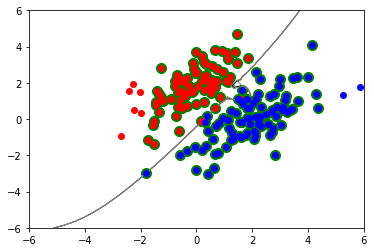

In [9]:
test_soft(gaussian_kernel)

This code was written with the help of the sentdex YouTube channel.

Docs: http://cvxopt.org/userguide/coneprog.html#quadratic-programming
Docs qp example: http://cvxopt.org/examples/tutorial/qp.html
Easier to understand: https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf